# B站：神奇的布欧
# 微信：l1243278923

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# 0. 判断GPU是否可用

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. 数据预处理

In [3]:
dataPath = "./MNIST"
train_data = torchvision.datasets.MNIST(
    root=dataPath,
    train=True,
    transform=transforms.ToTensor(),
    download=False
)
test_data = torchvision.datasets.MNIST(
    root=dataPath,
    train=False,
    transform=transforms.ToTensor(),
    download=False
)

In [4]:
# 数据集加载器
train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=True,
    drop_last=True
)
test_loader = Data.DataLoader(
    dataset=test_data,
    batch_size=64,
    shuffle=True,
    drop_last=True
)

In [5]:
for step, (b_x, b_y) in enumerate(train_loader):
    if step > 0:
        break
print(b_x.shape)
print(b_y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


# 2. 搭建模型

In [6]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim,
                          hidden_dim,
                          layer_dim,
                          batch_first=True,
                          nonlinearity='relu',
                          bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        out, h_n = self.rnn(x, None)
        out = self.fc(out[:, -1, :])
        return out

In [7]:
# 模型初始化
input_dim = 28
hidden_dim = 128
layer_dim = 2
output_dim = 10
model = Model(input_dim, hidden_dim, layer_dim, output_dim).to(device)

In [8]:
model

Model(
  (rnn): RNN(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

# 3. 训练

In [9]:
def train():
    optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
    loss_fun = nn.CrossEntropyLoss()
    train_loss_all = list()
    train_acc_all = list()
    model.train()
    for epoch in range(20):
        print("Epoch：" + str(epoch + 1))
        corrects = 0
        train_num = 0
        all_loss = 0
        for step, (x, y) in enumerate(train_loader):
            xData = x.view(-1, 28, 28)
            output = model(xData.to(device))
            pre_lab = torch.argmax(output.to("cpu"), 1)
            loss = loss_fun(output.to("cpu"), y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            all_loss += loss.item() * x.size(0)
            corrects += torch.sum(pre_lab == y.data)
            train_num += x.size(0)
        train_loss_all.append(all_loss / train_num)
        train_acc_all.append(corrects.double().item() / train_num)
        print(f"{epoch + 1}、loss：{train_loss_all[-1]:.4f}、Acc：{train_acc_all[-1]:.4f}")
    torch.save(model, "./手写数字分类.model")
    return train_loss_all, train_acc_all

In [10]:
train_loss_all, train_acc_all = train()

Epoch：1
1、loss：1.1337、Acc：0.6142
Epoch：2
2、loss：0.6687、Acc：0.7821
Epoch：3
3、loss：0.4867、Acc：0.8474
Epoch：4
4、loss：0.3788、Acc：0.8829
Epoch：5
5、loss：0.3067、Acc：0.9058
Epoch：6
6、loss：0.2589、Acc：0.9206
Epoch：7
7、loss：0.2265、Acc：0.9294
Epoch：8
8、loss：0.2049、Acc：0.9370
Epoch：9
9、loss：0.1861、Acc：0.9438
Epoch：10
10、loss：0.1734、Acc：0.9470
Epoch：11
11、loss：0.1603、Acc：0.9512
Epoch：12
12、loss：0.1499、Acc：0.9539
Epoch：13
13、loss：0.1414、Acc：0.9568
Epoch：14
14、loss：0.1337、Acc：0.9588
Epoch：15
15、loss：0.1254、Acc：0.9614
Epoch：16
16、loss：0.1202、Acc：0.9633
Epoch：17
17、loss：0.1134、Acc：0.9652
Epoch：18
18、loss：0.1095、Acc：0.9662
Epoch：19
19、loss：0.1034、Acc：0.9684
Epoch：20
20、loss：0.0991、Acc：0.9697


# 4. 测试

In [13]:
@torch.no_grad()
def test():
    model = torch.load("./手写数字分类.model").to("cpu")
    model.eval()
    x, y = next(iter(test_loader))
    xData = x.view(-1, 28, 28)
    output = model(xData)
    pre_lab = torch.argmax(output, 1)
    correct = torch.sum(pre_lab == y.data)
    total = len(y)
    print(pre_lab)
    print(y.data)
    print("准确率：" + str(correct / total))

In [14]:
test()

tensor([0, 0, 8, 6, 8, 3, 4, 6, 7, 0, 6, 1, 0, 7, 6, 0, 0, 7, 9, 7, 1, 4, 5, 6,
        2, 9, 2, 6, 6, 3, 8, 0, 2, 2, 5, 7, 2, 9, 4, 7, 9, 9, 6, 3, 7, 5, 8, 0,
        3, 4, 4, 6, 5, 0, 7, 8, 7, 8, 9, 3, 6, 8, 4, 5])
tensor([0, 0, 8, 6, 7, 3, 4, 6, 7, 0, 6, 1, 0, 7, 6, 0, 0, 7, 9, 7, 1, 4, 5, 6,
        2, 9, 2, 6, 6, 3, 7, 0, 2, 2, 5, 7, 2, 9, 4, 7, 9, 9, 6, 3, 7, 5, 8, 0,
        3, 4, 4, 6, 5, 0, 7, 8, 7, 8, 9, 3, 6, 8, 4, 5])
准确率：tensor(0.9688)


In [15]:
x, y = next(iter(test_loader))
model = torch.load("./手写数字分类.model").to("cpu")
xData = x.view(-1, 28, 28)
output = model(xData).argmax(1)

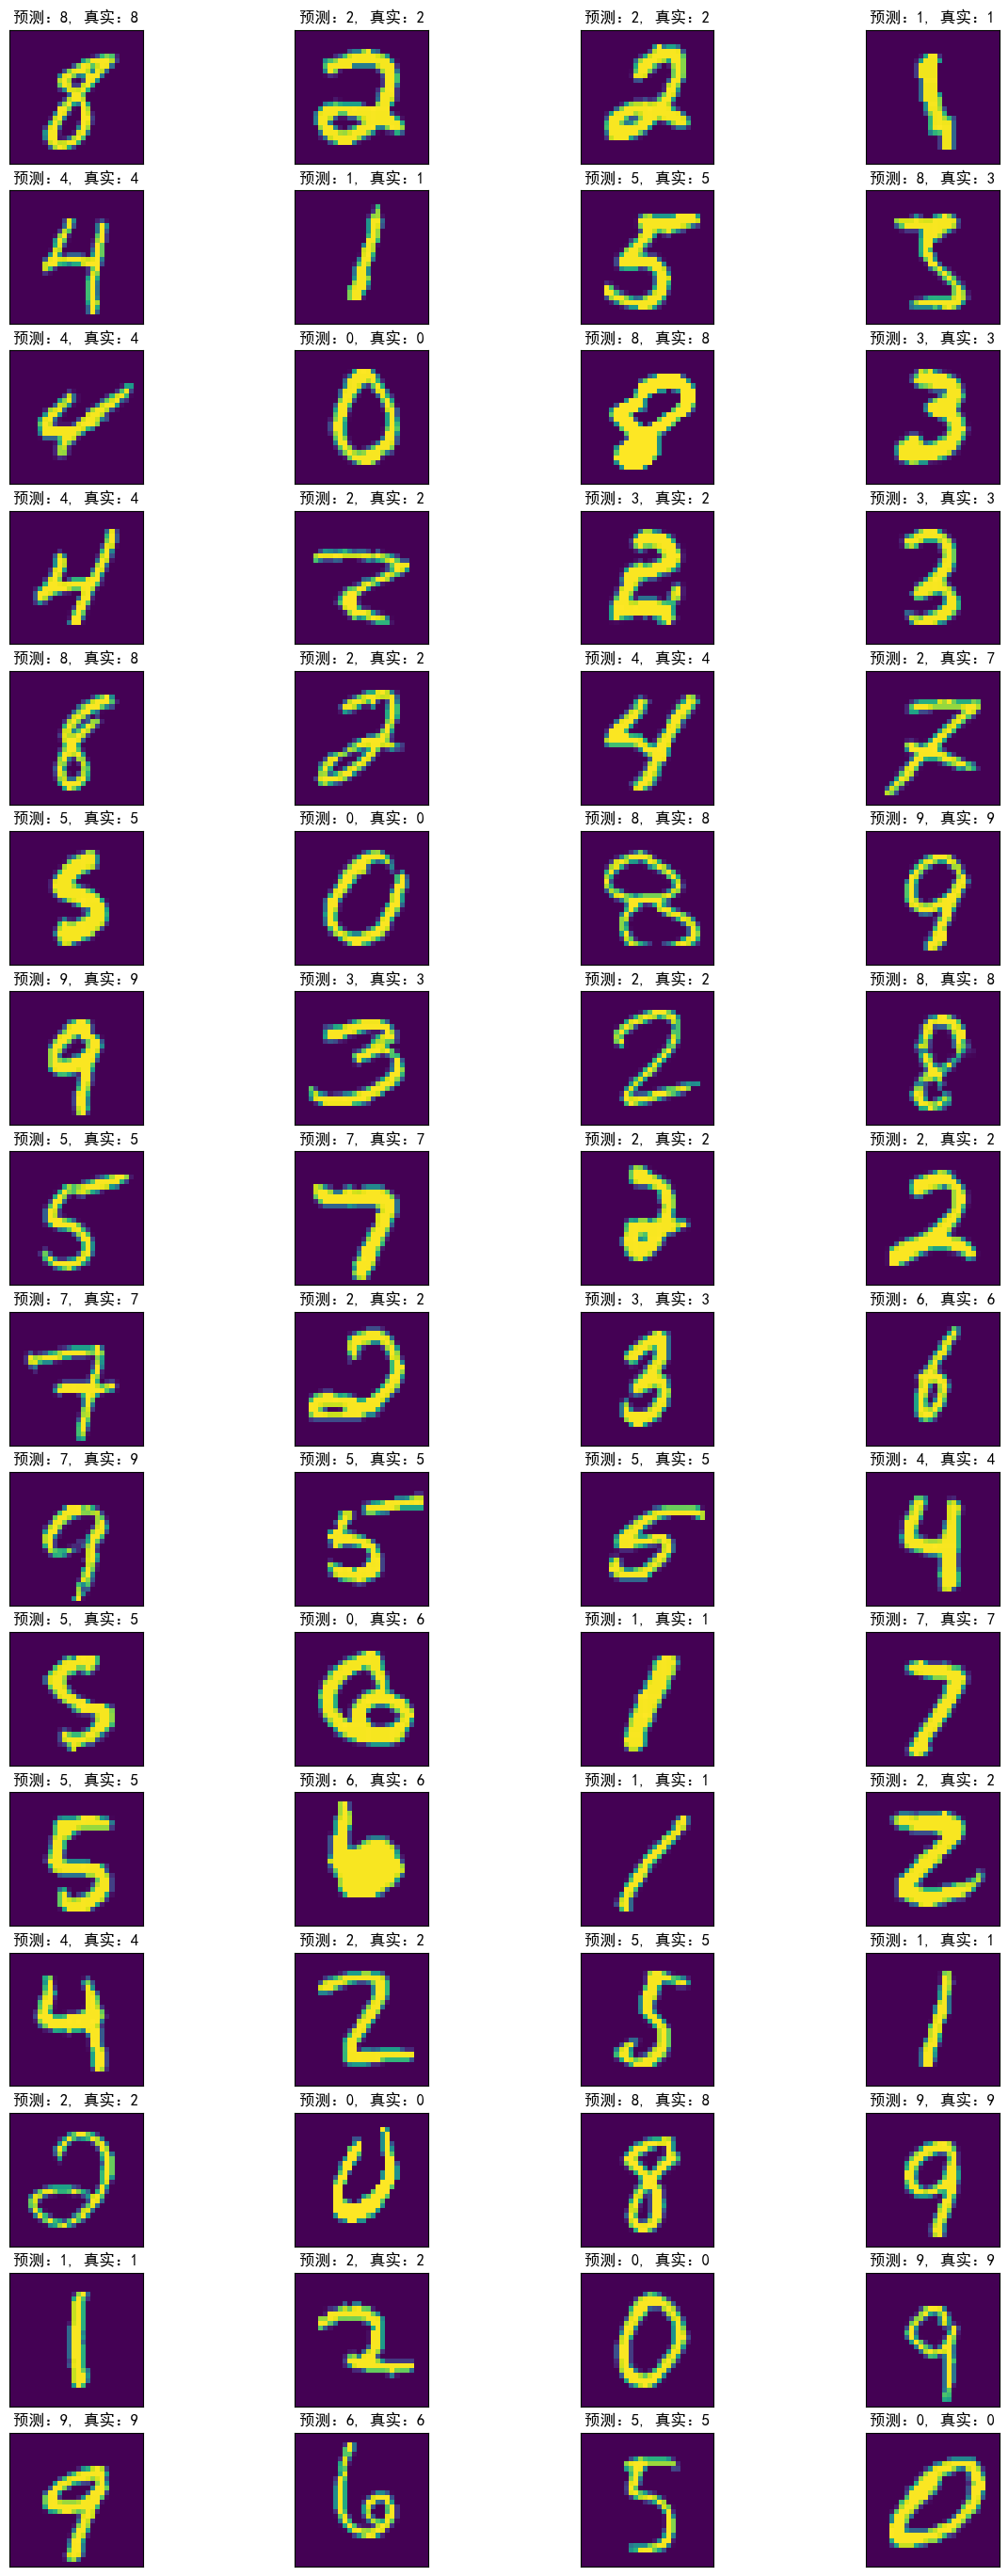

In [16]:
plt.rcParams['font.sans-serif'] = ['SimHei']
title = [f"预测：{pre}, 真实：{label}" for pre, label in zip(output.tolist(), y.tolist())]
images = [img for img in x.permute(0, 2, 3, 1).numpy()]
plt.figure(figsize=(15, 35))
for i in range(64):
    plt.subplot(16, 4, i + 1)
    plt.imshow(images[i])
    plt.title(title[i])
    plt.xticks([]), plt.yticks([])
plt.show()

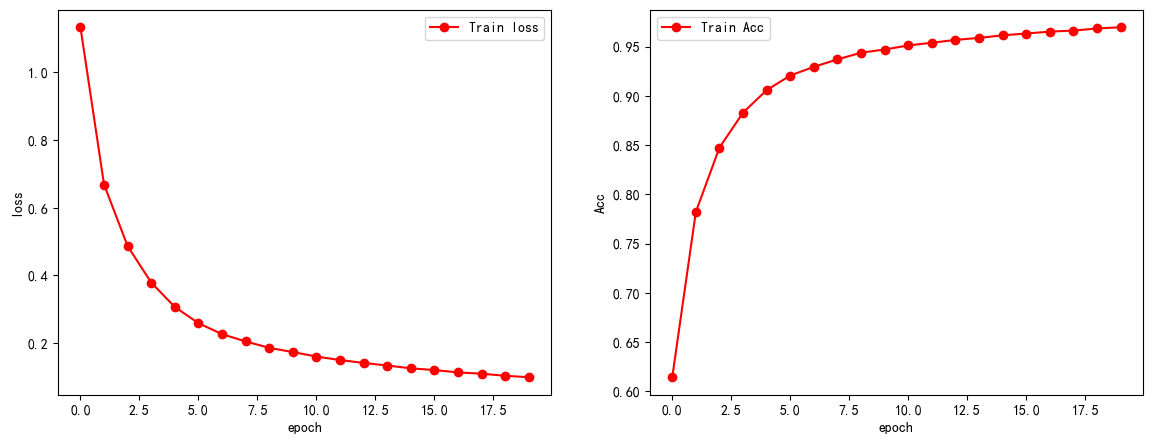

In [17]:
train_loss_all_np = list()
for i in range(20):
    train_loss_all_np.append(train_loss_all[i])
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all_np, "ro-", label="Train loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.subplot(1, 2, 2)
plt.plot(train_acc_all, "ro-", label="Train Acc")
plt.xlabel("epoch")
plt.ylabel("Acc")
plt.legend()
plt.show()